In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings("ignore")

In [2]:
# DATA PATH
RAW_DATA_PATH = os.path.join("..","datasets","raw","airline_passengers.csv")
RAW_DATA_PATH

'../datasets/raw/airline_passengers.csv'

In [3]:
air = pd.read_csv(RAW_DATA_PATH, parse_dates=['Month'], index_col='Month', squeeze=True)
air

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: AirPassengers, Length: 144, dtype: int64

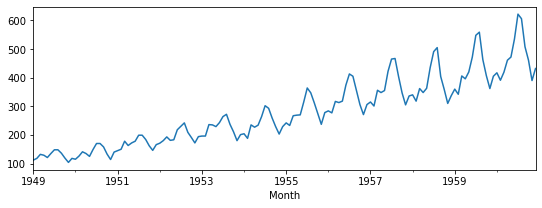

In [4]:
air.plot(figsize=(9,3))
plt.show()

## Time Series Decomposition

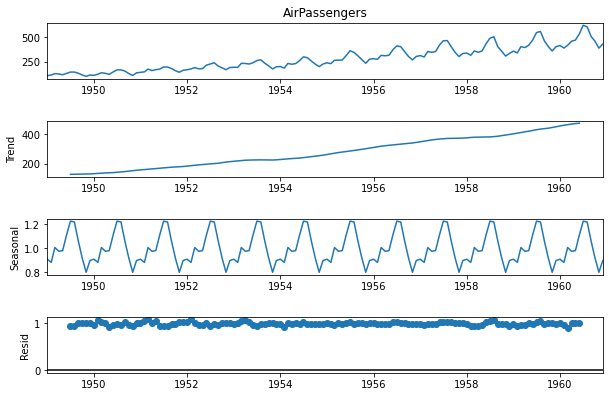

In [5]:
result = seasonal_decompose(air, model='multiplicative')
fig = result.plot()
fig.set_size_inches((9,6))
#plt.savefig('../img/seasonal_decompose.jpg')
plt.show()

## Augmented Dickey-Fuller Test

In [6]:
%run ../auxiliar_functions/ADFullerResults.py

ADFullerResults(air)

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


## Transformation

### Log

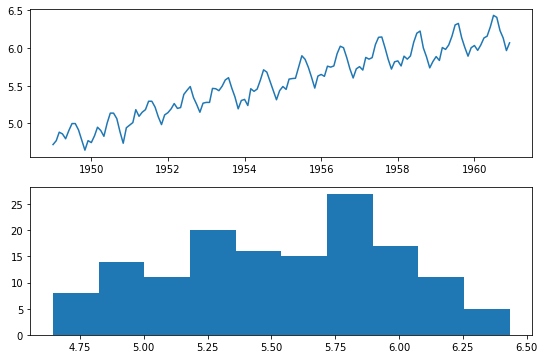

In [7]:
air_log = np.log(air)

plt.figure(figsize=(9,6))
plt.subplot(211)
plt.plot(air_log)
plt.subplot(212)
plt.hist(air_log)
plt.savefig('../img/log_transformed.png')
plt.show()

### Differencing 

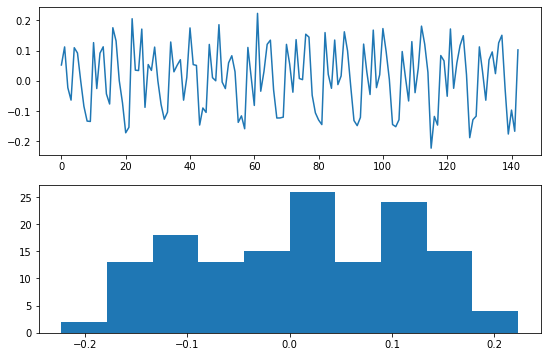

In [8]:
# Differencing - 1
air_diff = np.diff(air_log, n=1)

plt.figure(figsize=(9,6))
plt.subplot(211)
plt.plot(air_diff)
plt.subplot(212)
plt.hist(air_diff)
plt.savefig('../img/log_diff_transformed.png')
plt.show()

In [9]:
ADFullerResults(air_diff)

ADF Statistic: -2.717131
p-value: 0.071121
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


### Seasonal Differencing 

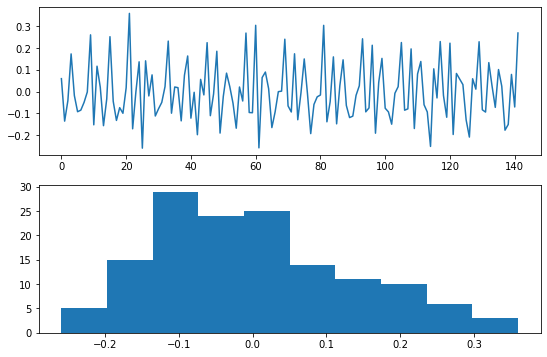

In [10]:
air_transformed = np.diff(air_diff, n=1)

plt.figure(figsize=(9,6))
plt.subplot(211)
plt.plot(air_transformed)
plt.subplot(212)
plt.hist(air_transformed)
plt.savefig('../img/transformed_diff2_ts.png')
plt.show()

### Testing Stationarity - Transformed Time Series

In [11]:
ADFullerResults(air_transformed)

ADF Statistic: -8.196629
p-value: 0.000000
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


In [12]:
len(air_transformed)

142

## Autocorrelation and Partial Autocorrelation

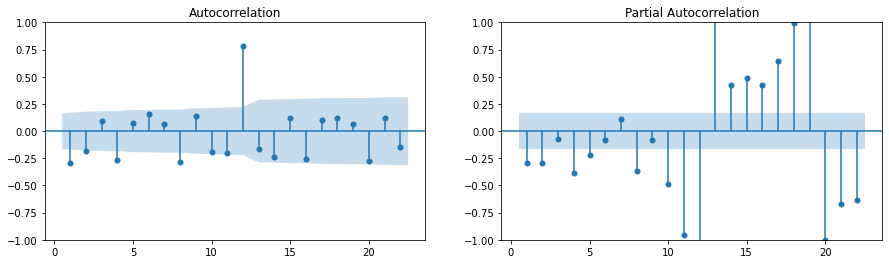

In [13]:
# Autocorrelation Plot
fig, ax = plt.subplots(1,2, figsize=(15,4))
plot_acf(air_transformed, zero=False, ax=ax[0])
plot_pacf(air_transformed, zero=False, ax=ax[1])
plt.show()

## Searching for best order

In [14]:
akaike = list()
p_orders = np.arange(1,13,1)
q_orders = np.arange(1,13,1)
d = 2

for p in p_orders:
    for q in q_orders:
        try:
            model = ARIMA(air_transformed, order=(p,d,q))
            res = model.fit()
            akaike.append([p,q, round(res.aic, 1)])
        except:
            akaike.append([p,q, None])

aic_ = pd.DataFrame(akaike, columns=["p","q","aic"])
aic_top = aic_.sort_values(by="aic", ignore_index=True)
aic_top.reset_index(drop=True)[:5]

,p,q,aic
0,12,10,-390.1
1,12,11,-383.5
2,12,9,-383.2
3,12,6,-383.1
4,12,8,-379.2


In [21]:
p = aic_top['p'][6] # Best MA(q) order
q = aic_top['q'][6] # Best AR(p) prder

model = ARIMA(air_transformed, order=(p,d,q))
model_fitted = model.fit()
print(model_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  142
Model:                ARIMA(12, 2, 7)   Log Likelihood                 205.449
Date:                Sat, 27 Aug 2022   AIC                           -370.897
Time:                        09:58:09   BIC                           -312.064
Sample:                             0   HQIC                          -346.989
                                - 142                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9217      0.059    -32.426      0.000      -2.038      -1.806
ar.L2         -1.9409      0.086    -22.444      0.000      -2.110      -1.771
ar.L3         -1.9507      0.102    -19.078      0.0

## Diagnostics

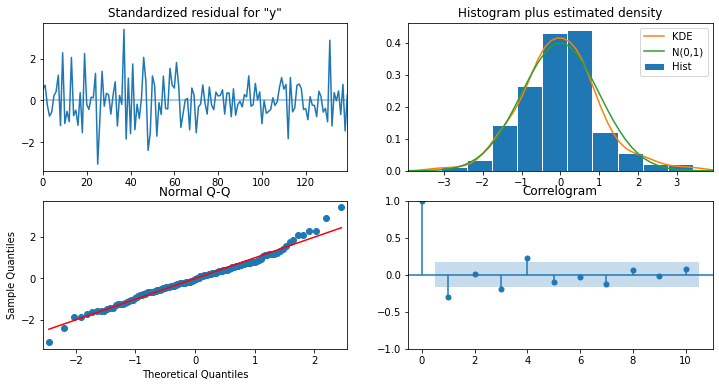

In [23]:
model_fitted.plot_diagnostics(figsize=(12,6))
plt.savefig('../img/diagnostic_plots.png')
plt.show()

### Ljung-Box Test

In [24]:
acorr_ljungbox(model_fitted.resid, lags=12)

,lb_stat,lb_pvalue
1,4.837507,0.027847
2,6.726306,0.034626
3,17.315371,0.000609
4,20.185683,0.000459
5,20.560388,0.000981
6,21.081620,0.001774
7,21.599429,0.002977
8,22.255590,0.004464
9,22.736797,0.006815
10,24.112391,0.007308
